In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [6]:
class Simulator:
    def __init__(self, init_node_number=20, meam_number=200, layer_number=20, node_birth_rate=0, node_die_rate=0, edge_add_rate=0, edge_delete_rate=0, meam_generation_rate_per_node=0.01, meam_forget_rate=0.01, meam_leac_rate_per_node=0.05, mean_transmittion_rate=0.05):
        self.existing_meams = set()
        self.all_meams = set([i for i in range(meam_number)])
        self.existing_layers = set(np.random.randint(0,layer_number,max(5, layer_number//10)))
        self.all_layers = set([i for i in range(layer_number)])
        self.existing_nodes = set([i for i in range(init_node_number)])
        self.node_birth_rate = node_birth_rate
        self.edge_add_rate = edge_add_rate
        self.node_die_rate = node_die_rate
        self.edge_delete_rate = edge_delete_rate
        self.meam_generation_rate_per_node = meam_generation_rate_per_node
        self.meam_forget_rate = meam_forget_rate
        self.meam_leac_rate_per_node = meam_leac_rate_per_node
        self.mean_transmittion_rate = mean_transmittion_rate
        self.layer_prevalence_arr = np.zeros(layer_number)# レイヤー普及度ndarray
        self.meam_prevalence_arr = np.zeros(meam_number)# ミーム普及度ndarray
        self.follower_count_dic = {}
        self.whole_graph = nx.DiGraph()
        self.initialize_whole_graph()
        self.layer_graphs = {}
        self.apdate_layer_graph()
    
    def initialize_whole_graph(self):
        self.whole_graph.add_node(0)
        for n1 in range(1,len(self.existing_nodes)):   #   ノード番号が大きいノードは、小さいノードから一つ選んでエッジを向ける
            n0 = np.random.choice(n1)
            nx.add_path(self.whole_graph, [n0, n1])
            layer = np.random.choice(list(self.existing_layers))
            self.whole_graph.add_edges_from([(n0,n1,{layer:{"waight":np.random.rand()}})])
            self.whole_graph.add_nodes_from([(n0, {layer:{"meam":set()}})])
            self.whole_graph.add_nodes_from([(n1, {layer:{"meam":set()}})])
            self.whole_graph.nodes()[n0][layer] = {"meam":set()}
            self.whole_graph.nodes()[n1][layer] = {"meam":set()}
        
        for n0 in range(len(self.existing_nodes)):     #   エッジが双方向にありうるように、エッジの追加
            n1 = np.random.choice(len(self.existing_nodes))
            if n0 == n1:
                continue
            nx.add_path(self.whole_graph, [n1, n0])
            layer = np.random.choice(list(self.existing_layers))
            self.whole_graph.add_edges_from([(n1,n0,{layer:{"waight":np.random.rand()}})])
            self.whole_graph.nodes()[n0][layer] = {"meam":set()}
            self.whole_graph.nodes()[n1][layer] = {"meam":set()}
        
        #self.run(times=20)
        
    def apdate_layer_graph(self):   #   全体グラフからレイヤーごとにネットワークを抽出
        self.layer_graphs = {}
        for layer in deepcopy(self.existing_layers):
            layer_DiGraph = nx.DiGraph()
            for n, info in self.whole_graph.nodes.data():
                if layer in info:
                    layer_DiGraph.add_node(n)
                    layer_DiGraph.add_nodes_from([(n, info)])

            for n0, n1, info in self.whole_graph.edges.data(layer):
                if info is None:
                    continue
                meam_set_0 = self.whole_graph.nodes()[n0][layer]["meam"]
                meam_set_1 = self.whole_graph.nodes()[n1][layer]["meam"]
                nx.add_path(layer_DiGraph, [n1,n0])
                layer_DiGraph.add_edges_from([(n1,n0,{layer:{"waight":info["waight"]}})])
                if layer in layer_DiGraph.nodes()[n0]:
                    layer_DiGraph.nodes()[n0][layer]["meam"] = layer_DiGraph.nodes()[n0][layer]["meam"] | meam_set_0
                else:
                    layer_DiGraph.nodes()[n0][layer] = {"meam":meam_set_0}
                if layer in layer_DiGraph.nodes()[n1]:
                    layer_DiGraph.nodes()[n1][layer]["meam"] = layer_DiGraph.nodes()[n1][layer]["meam"] | meam_set_1
                else:
                    layer_DiGraph.nodes()[n1][layer] = {"meam":meam_set_1}

            if layer_DiGraph.nodes():
                self.layer_graphs[layer] = layer_DiGraph
    
    def cal_prevalence_arr(self):   #   レイヤーとミームの普及度を計算する
        self.meam_prevalence_arr[:] = 0
        self.layer_prevalence_arr[:] = 0
        for node_n in self.whole_graph.nodes():
            for layer in self.whole_graph.nodes()[node_n]:
                self.layer_prevalence_arr[layer] += 1
                meam_set = self.whole_graph.nodes()[node_n][layer]["meam"]
                for meam in meam_set:
                    self.meam_prevalence_arr[meam] += 1

    def cal_waight(self, prevalence_arr, number_set, constriction=False):
        number_lst, waight_arr = list(number_set), np.zeros(len(number_set))
        number_lst.sort()
        if constriction:
            for i in range(len(number_lst)):
                waight_arr[i] = prevalence_arr[i]
        else:
            for i, num in enumerate(number_lst):
                waight_arr[i] = prevalence_arr[num]
        number_arr = np.array(number_lst)
        waight_arr /= np.sum(waight_arr)
        return number_arr, waight_arr
    
    def cal_random_round_int(self, a):
        if a < 0:
            return 0
        round_a = int(a)
        if np.random.rand() < a % 1:
            round_a += 1
        return round_a

    def cal_existing_layers(self):
        existing_layers = set()
        for n, info in self.whole_graph.nodes.data():
            for layer in info:
                existing_layers = existing_layers | set([layer])
        self.existing_layers = existing_layers

    def birth_of_meams(self):
        self.cal_prevalence_arr()
        for n in self.existing_nodes:
            if np.random.rand() < self.meam_generation_rate_per_node:
                birth_meam = np.random.choice(list(self.all_meams))
                prevalence_lst, layers_lst = [], []
                for layer in self.whole_graph.nodes()[n]:
                    prevalence_lst.append(self.layer_prevalence_arr[layer])
                    layers_lst.append(layer)
                number_arr, waight_arr = self.cal_waight(prevalence_lst, layers_lst, constriction=True)
                [birth_layer] = np.random.choice(number_arr, p=waight_arr, size=1)
                #print(f"meam {birth_meam} is birth in (node {n}, layer {birth_layer})")
                if birth_meam in self.existing_meams:
                    continue
                self.existing_meams.add(birth_meam)

                self.whole_graph.nodes()[n][birth_layer]["meam"].add(birth_meam)

    def birth_of_nodes(self):
        self.cal_prevalence_arr()
        N = self.cal_random_round_int(self.node_birth_rate*len(self.existing_nodes))
        for _ in range(N):
            birth_node = max(self.existing_nodes) + 1
            self.whole_graph.add_node(birth_node)
            prevalence_arr, waight_arr = self.cal_waight(self.layer_prevalence_arr, self.existing_layers)
            layers_lst = np.random.choice(prevalence_arr, p=waight_arr, size=max(len(self.existing_layers)//10, 1))
            for layer in layers_lst:
                self.whole_graph.add_nodes_from([(birth_node, {layer:{"meam":set()}})])
            self.existing_nodes.add(birth_node)

    def die_of_nodes(self):
        N = self.cal_random_round_int(self.node_die_rate*len(self.existing_nodes))
        for _ in range(N):
            die_node = np.random.choice(list(self.existing_nodes))
            self.whole_graph.remove_node(die_node)
            self.existing_nodes.remove(die_node)
        self.cal_existing_layers()
    
    # エッジの確率的追加
    def add_edges(self):  # 同じレイヤーのノードをつなぐように変更、同じレイヤーを持つノードのみ
        self.cal_prevalence_arr()
        N = self.cal_random_round_int(self.edge_add_rate*len(self.existing_nodes))
        edge_counter = 0
        for _, _, info in self.whole_graph.edges.data():
            edge_counter += len(info)
        N = min(N, (len(self.existing_nodes) - 1)**2 - edge_counter)

        new_edge_candidates = []
        for n0, info0 in self.whole_graph.nodes.data():
            layer_set_0 = set(list(info0.keys()))
            for n1, info1 in self.whole_graph.nodes.data():
                layer_set_1 = set(list(info1.keys()))
                path_layer_set = layer_set_0 & layer_set_1
                if n0 != n1 and path_layer_set:
                    new_edge_candidates.append((n0, n1, list(path_layer_set)))
        np.random.shuffle(new_edge_candidates)
        counter = 0
        while new_edge_candidates and counter < N:
            n0, n1, path_layer_lst = new_edge_candidates.pop()
            path_layer = np.random.choice(path_layer_lst)
            if (n0, n1) in self.whole_graph.edges():
                edge_info = self.whole_graph.edges()[(n0, n1)]
                if path_layer in edge_info:
                    edge_info[path_layer]["waight"] = min(1, edge_info[path_layer]["waight"] + np.random.rand())
                else:
                    edge_info[path_layer] = {"waight": np.random.rand()}
            else:
                self.whole_graph.add_edge(n0, n1)
                self.whole_graph.add_edges_from([(n0, n1, {path_layer: {"waight": np.random.rand()}})])
            counter += 1
                
    # エッジの太さの確率的変動(上限あり), 太さが0以下のエッジの削除
    def change_edges_width(self):
        self.deleted_edge_num = 0
        self.edge_counter = 0
        for n0, n1, info in deepcopy(self.whole_graph.edges.data()):
            for layer in deepcopy(info):
                info[layer]["waight"] = min(1, max(0, info[layer]["waight"] + 0.1*np.random.randn()))
                self.edge_counter += 1
                if info[layer]["waight"] == 0:
                    del info[layer]
                    if not info:
                        self.whole_graph.remove_edge(n0, n1)
                    self.deleted_edge_num += 1
                    self.edge_counter -= 1

    # エッジの確率的削除、太さが0以下になって削除したエッジの数を覚えておいて、その分削除確立を下げる
    def delete_edges(self):
        N = self.cal_random_round_int(self.edge_delete_rate * (self.edge_counter - self.deleted_edge_num))
        edge_lst = list(self.whole_graph.edges())
        np.random.shuffle(edge_lst)
        for _ in range(N):
            n0, n1 = edge_lst.pop()
            self.whole_graph.remove_edge(n0, n1)

    # レイヤーの確率的追加
    def add_existing_layers_2_nodes(self):  #   既存のレイヤーをほかのノードにも伝搬する
        #   すべての既存のレイヤーについて、普及度に比例する確率で伝搬する
        for layer in self.existing_layers:
            N = self.cal_random_round_int(self.node_die_rate * self.layer_prevalence_arr[layer])
            node_lst = list(self.whole_graph.nodes())
            np.random.shuffle(node_lst)
            for _ in range(N):
                n = node_lst.pop()
                if layer not in self.whole_graph.nodes()[n]:
                    self.whole_graph.nodes()[n][layer] = {"meam":set()}

    def add_new_layers_2_nodes(self):   #   今無いレイヤーをランダムに選んだノードに追加する
        N = max(0, self.cal_random_round_int(len(self.all_layers)/3 - len(self.existing_layers)))
        non_existing_layers_lst = list(self.all_layers - self.existing_layers)
        np.random.shuffle(non_existing_layers_lst)
        for _ in range(N):
            n = np.random.choice(list(self.existing_nodes))
            info = self.whole_graph.nodes.data()[n]
            new_layer = non_existing_layers_lst.pop()
            info[new_layer] = {"meam":set()}
        self.cal_existing_layers()

    def del_edge_4_node_layer(self, node, layer):
        for n0, n1, info in deepcopy(self.whole_graph.edges.data()):
            if (n0 == node or n1 == node) and layer in info:
                del info[layer]
                if not info:
                    self.whole_graph.remove_edge(n0,n1)

    # レイヤーの確率的削除 & 所属するレイヤーがなくなったノードの削除
    def delete_layers(self):
        layer_prevalence_sum = self.cal_random_round_int(np.sum(self.layer_prevalence_arr))
        layer_prevalence_limit = self.cal_random_round_int(len(self.whole_graph.nodes()))
        N = max(0, layer_prevalence_limit - layer_prevalence_sum)
        for _ in range(N):
            if np.random.rand() < 0.5:
                continue
            n = np.random.choice(list(self.existing_nodes))
            info = self.whole_graph.nodes()[n]
            del_layer = np.random.choice(list(info.keys()))
            del info[del_layer]
            #   ここで、始点か終点のどちらかがノードn、レイヤーがdel_layerのエッジをすべて削除する
            self.del_edge_4_node_layer(n, del_layer)
            if not info:
                self.whole_graph.remove_node(n)
                self.existing_nodes.remove(n)
        self.cal_existing_layers()
        
    # ミームの確率的伝搬
    def meam_leac(self):    #   ノード内のミーム伝搬
        for node in self.whole_graph.nodes():
            info = self.whole_graph.nodes()[node]
            if len(info) < 2:
                continue
            leac_layer = np.random.choice(list(info.keys()))
            meam_set = info[leac_layer]["meam"]

            N = self.cal_random_round_int(len(meam_set)*self.meam_leac_rate_per_node)
            meam_lst = list(meam_set)
            np.random.shuffle(meam_lst)
            for _ in range(N):
                leac_meam = meam_lst.pop()
                to_layer = leac_layer
                while to_layer == leac_layer:
                    to_layer = np.random.choice(list(info.keys()))
                info[to_layer]["meam"].add(leac_meam)
                    
    def meam_transmission(self):    #   ミームの、エッジを通じた伝搬
        new_G = deepcopy(self.whole_graph)
        for n0, n1, edge_info in self.whole_graph.edges.data():
            for edge_layer in edge_info:
                node0_info = self.whole_graph.nodes()[n0]
                node1_info = self.whole_graph.nodes()[n1]
                if edge_layer in node0_info and edge_layer in node1_info:
                    meam_set = node0_info[edge_layer]["meam"]
                    N = self.cal_random_round_int(len(meam_set)*self.mean_transmittion_rate)
                    meam_lst = list(meam_set)
                    np.random.shuffle(meam_lst)
                    for _ in range(N):
                        trans_meam = meam_lst.pop()
                        new_G.nodes()[n1][edge_layer]["meam"].add(trans_meam)
        self.whole_graph = new_G

    # ミームの確率的削除と現役ミームの集合の更新
    def del_and_cal_existing_meam(self):
        new_exist_meam, completely_spread_meam = set(), self.all_meams
        for n, info in self.whole_graph.nodes.data():
            meam_41_node = set()
            for layer in list(info.keys()):
                meam_lst = list(info[layer]["meam"])
                N = self.cal_random_round_int(self.meam_forget_rate*len(meam_lst))
                np.random.shuffle(meam_lst)
                for _ in range(N):
                    remove_meam = meam_lst.pop()
                    info[layer]["meam"].remove(remove_meam)
                new_exist_meam = new_exist_meam | set(meam_lst)
        
                #   すべてのノードが持つに至ったミームは、名前を出力してノードから削除
                meam_41_node = meam_41_node | set(meam_lst)
            completely_spread_meam = completely_spread_meam & meam_41_node
        if completely_spread_meam:
            for meam in completely_spread_meam:
                print(f"meam {meam} completely spread")
                for n, info in self.whole_graph.nodes.data():
                    for layer in list(info.keys()):
                        info[layer]["meam"] = info[layer]["meam"] - set([meam])
            print()
        
        self.existing_meams = new_exist_meam - completely_spread_meam

    #   一単位時間、シミュレーションを実行
    def run(self, times=1, timecall=False):
        for t in range(times):
            self.die_of_nodes()
            self.birth_of_nodes()
            self.add_edges()
            self.change_edges_width()
            self.delete_edges()
            self.add_existing_layers_2_nodes()
            self.add_new_layers_2_nodes()
            self.delete_layers()
            self.birth_of_meams()
            self.meam_leac()
            self.meam_transmission()
            self.del_and_cal_existing_meam()

            self.cal_existing_layers()

            if timecall:
                print(f"time={t+1}")

        self.apdate_layer_graph()

    def plot_whole_graph(self):
        nx.draw_networkx(self.whole_graph)
        plt.show()
    
    def plot_layer_graphs(self):
        for layer in self.layer_graphs:
            print(f"layer={layer}")
            nx.draw_networkx(self.layer_graphs[layer])
            plt.show()
            print()
    
    #   誰と誰が同じミームを共有しているかを表すネットワークを出力
    def plot_meam_network(self):
        node_meamset_lst = []
        for n, info in self.whole_graph.nodes.data():
            meam_set = set()
            for layer in info:
                meam_set = meam_set | info[layer]["meam"]
            node_meamset_lst.append((n, meam_set))
        for meam in self.existing_meams:
            t = []
            G = nx.Graph()
            for n, meam_set in node_meamset_lst:
                if meam in meam_set:
                    G.add_node(n)
                    t.append(n)
            for i in range(len(t)-1):
                for j in range(i+1, len(t)):
                    edges = list(self.whole_graph.edges())
                    n0 = t[i]
                    n1 = t[j]
                    if ((n0, n1) in edges) or ((n1,n0) in edges):
                        G.add_edge(n0, n1)
            print(f"meam = {meam}")
            nx.draw_networkx(G)
            plt.show()
            print()


In [7]:
simulator0 = Simulator()

In [8]:
simulator0.run(times=100)

layer=2


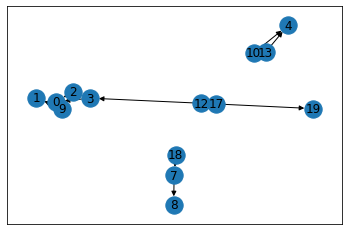


layer=4


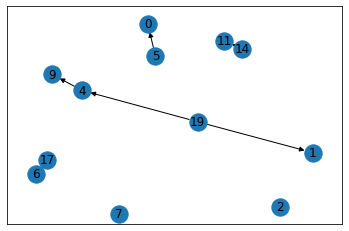


layer=5


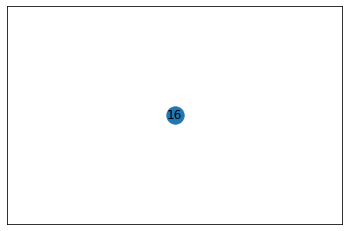


layer=7


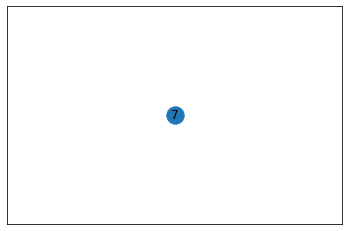


layer=8


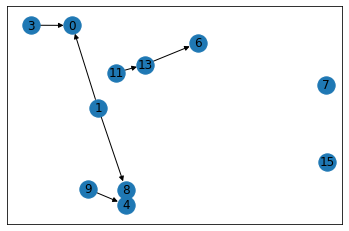


layer=9


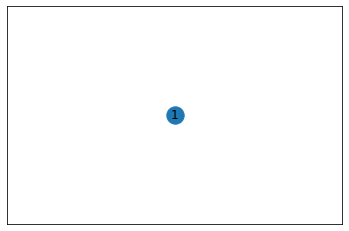


layer=12


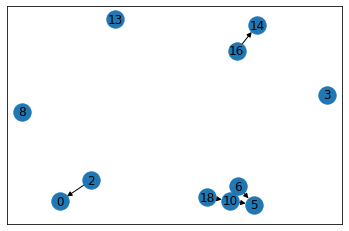


layer=15


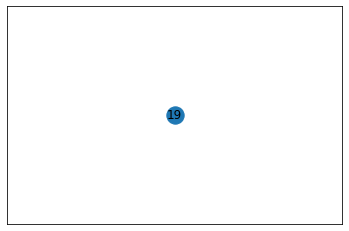

In [9]:
simulator0.plot_layer_graphs()

meam = 65


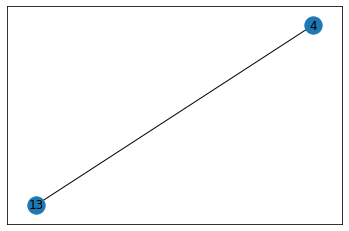


meam = 194


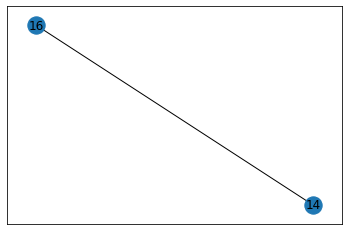


meam = 67


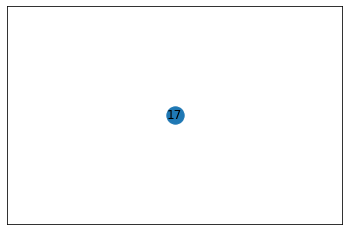


meam = 131


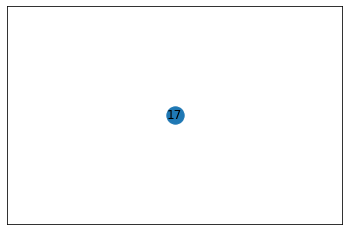


meam = 133


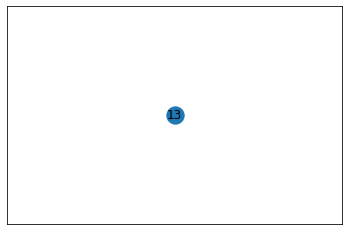


meam = 68


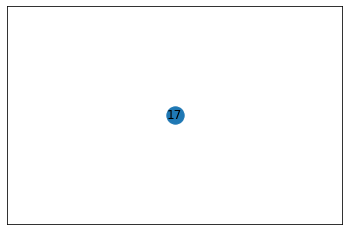


meam = 5


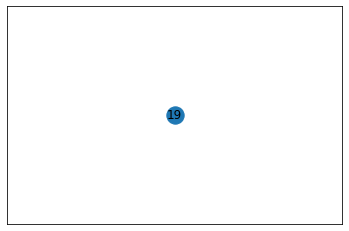


meam = 153


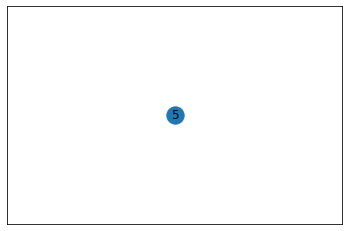


meam = 28


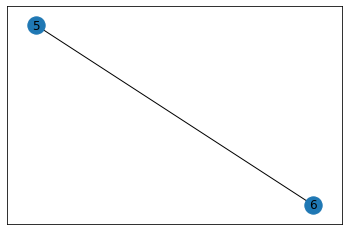


meam = 157


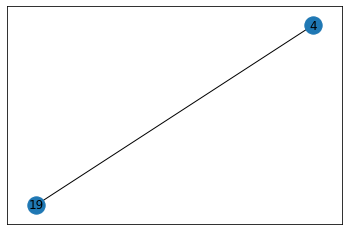


meam = 94


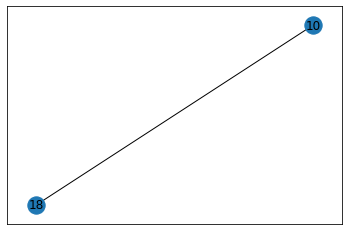


meam = 97


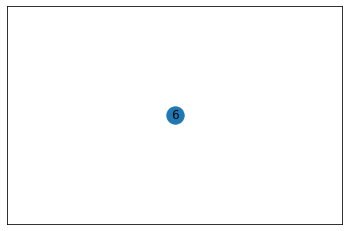


meam = 164


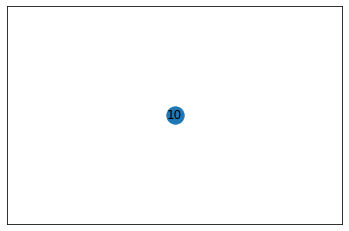


meam = 169


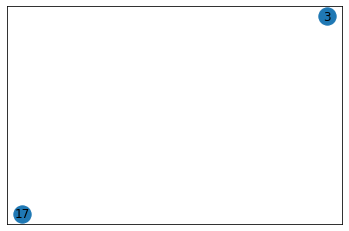


meam = 178


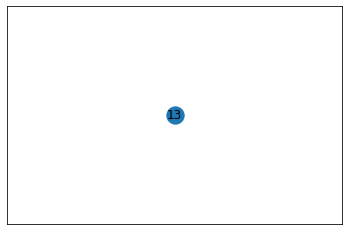


meam = 55


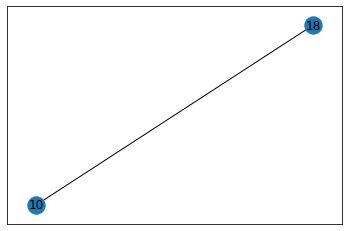


meam = 185


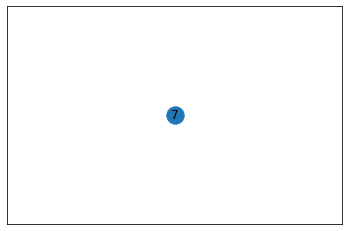


meam = 59


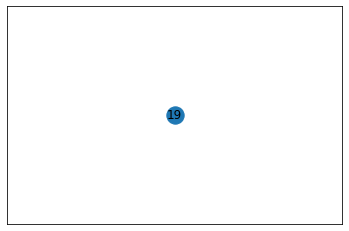


meam = 188


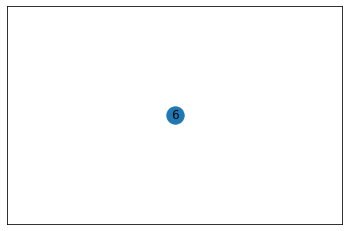

In [10]:
simulator0.plot_meam_network()

In [11]:
simulator1 = Simulator(init_node_number=20, meam_number=200, layer_number=20, meam_generation_rate_per_node=0.1, node_birth_rate=0.005, node_die_rate=0.0045, edge_add_rate=0.2, edge_delete_rate=0.1, meam_forget_rate=0.01, meam_leac_rate_per_node=0.1, mean_transmittion_rate=0.1)

In [12]:
simulator1.run(times=100)

meam 117 completely spread



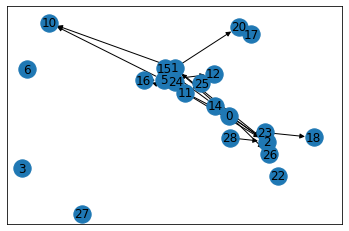

In [13]:
simulator1.plot_whole_graph()

layer=0


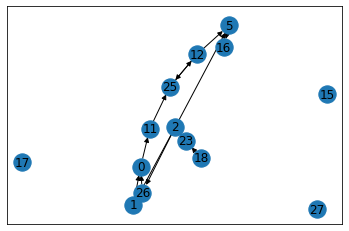


layer=3


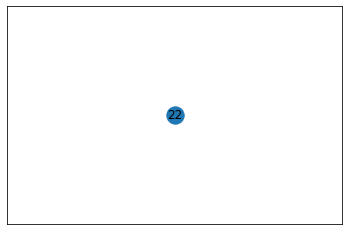


layer=6


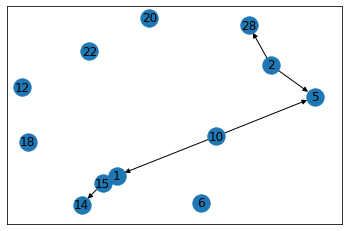


layer=7


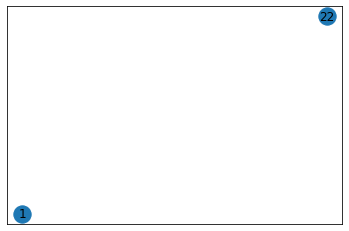


layer=9


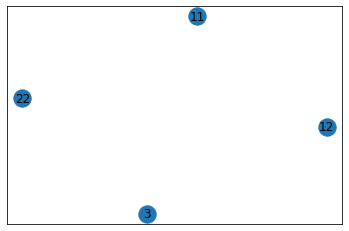


layer=10


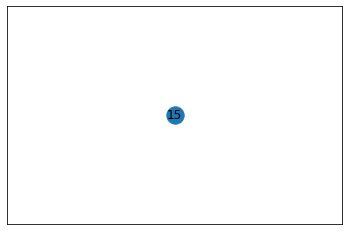


layer=14


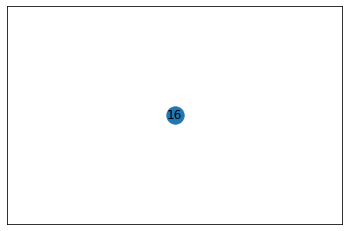


layer=18


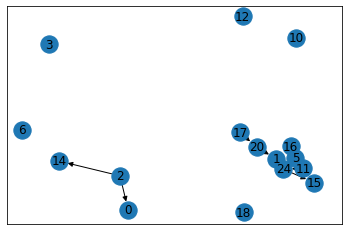

In [14]:
simulator1.plot_layer_graphs()

meam = 0


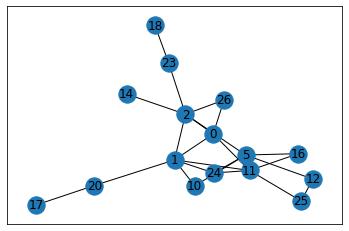


meam = 1


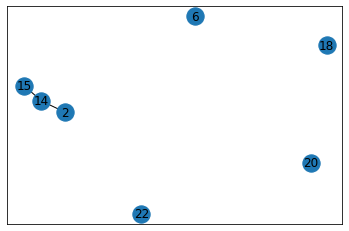


meam = 2


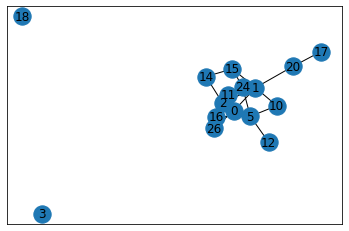


meam = 3


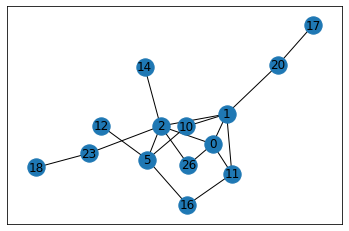


meam = 4


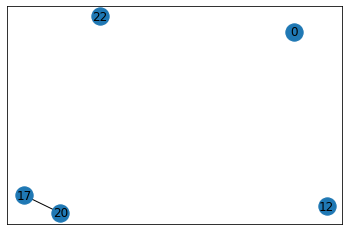


meam = 5


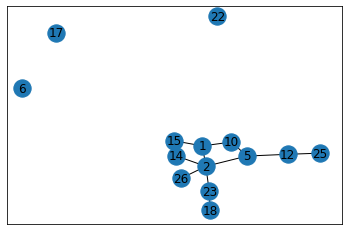


meam = 6


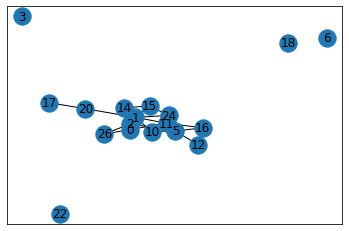


meam = 7


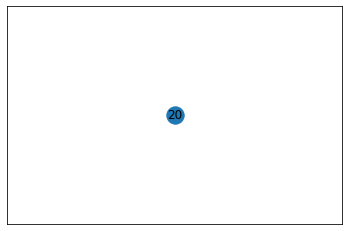


meam = 9


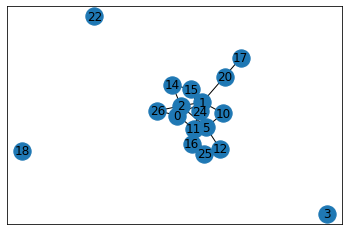


meam = 10


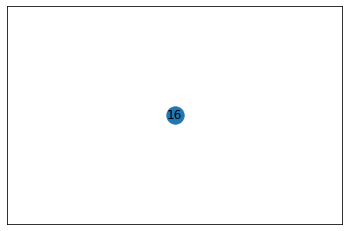


meam = 12


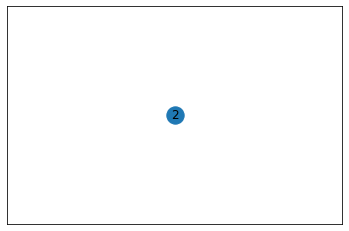


meam = 13


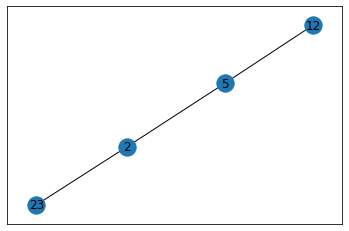


meam = 14


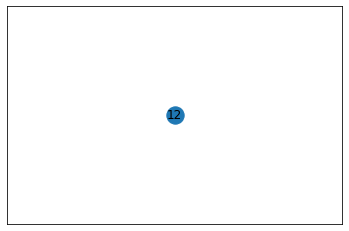


meam = 15


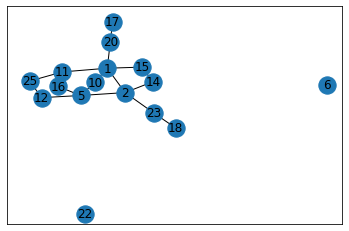


meam = 19


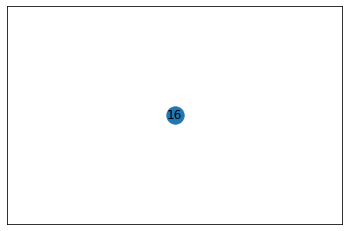


meam = 21


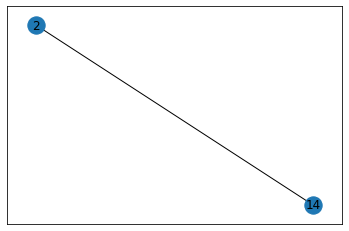


meam = 23


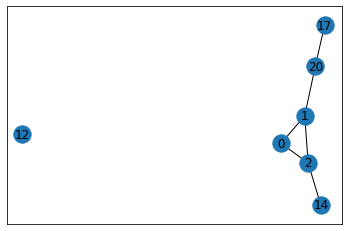


meam = 32


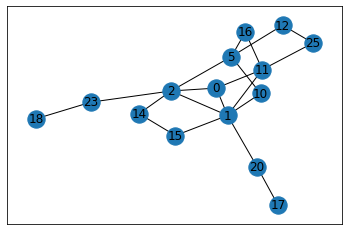


meam = 33


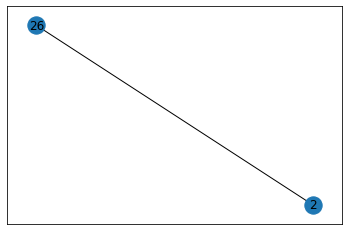


meam = 39


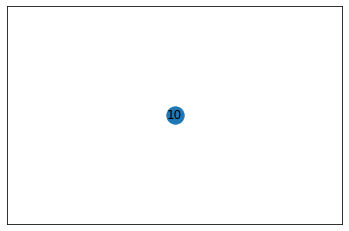


meam = 40


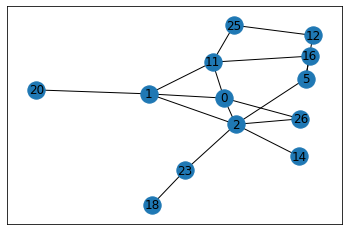


meam = 41


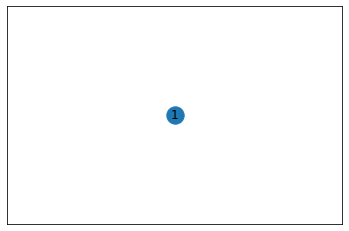


meam = 42


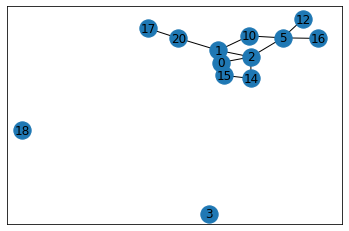


meam = 43


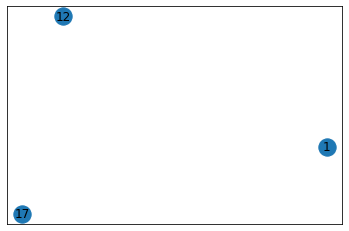


meam = 46


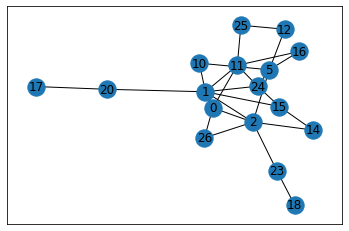


meam = 47


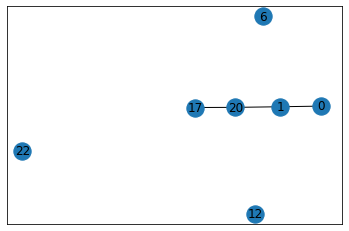


meam = 48


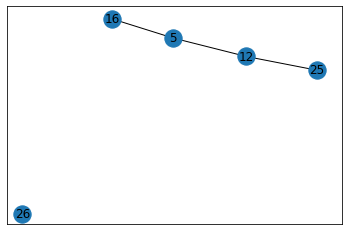


meam = 49


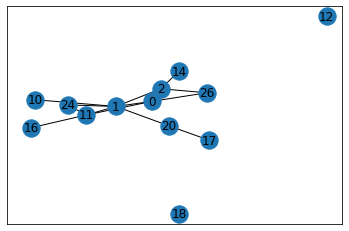


meam = 50


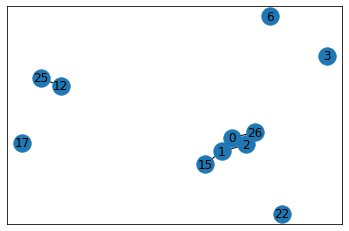


meam = 53


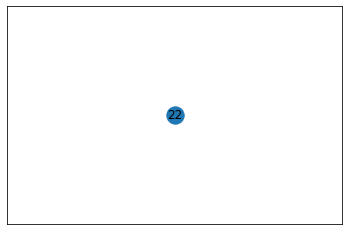


meam = 54


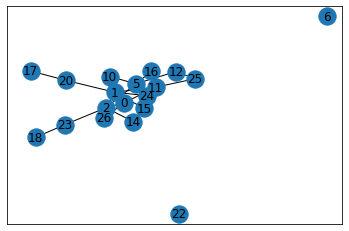


meam = 55


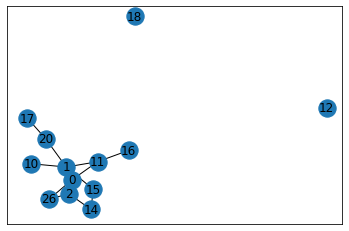


meam = 56


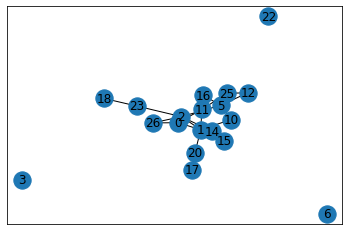


meam = 57


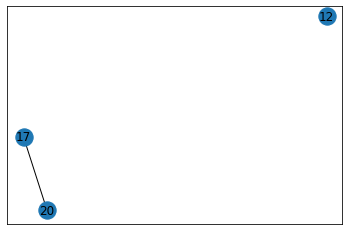


meam = 58


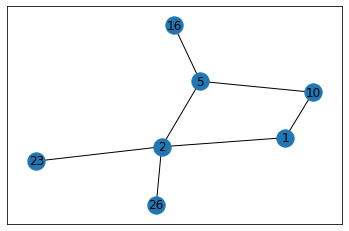


meam = 62


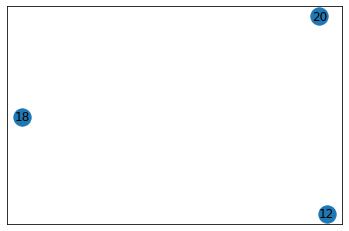


meam = 64


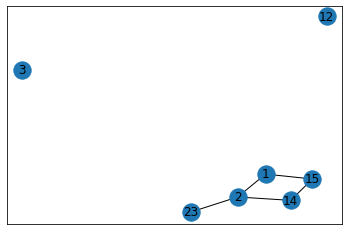


meam = 65


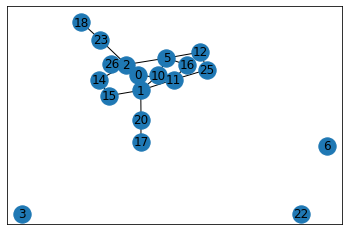


meam = 68


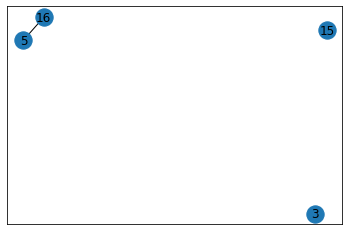


meam = 71


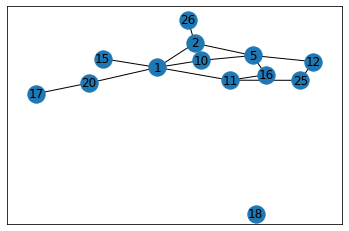


meam = 73


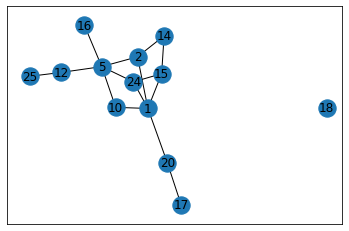


meam = 75


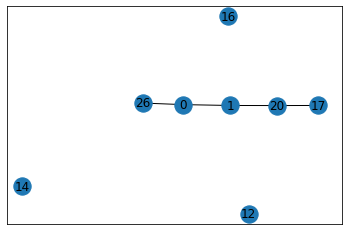


meam = 76


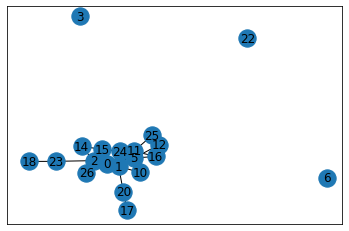


meam = 79


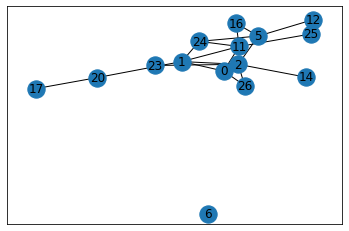


meam = 80


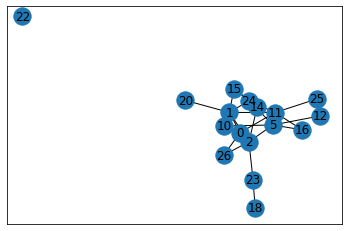


meam = 82


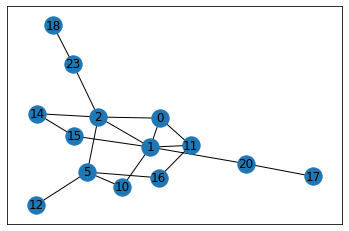


meam = 83


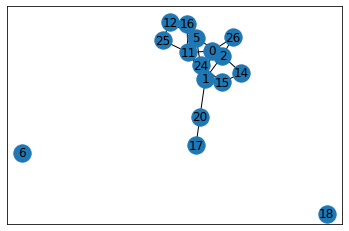


meam = 84


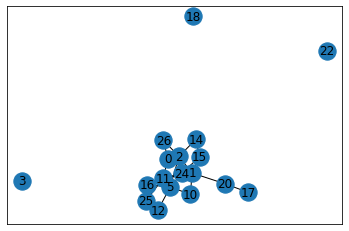


meam = 87


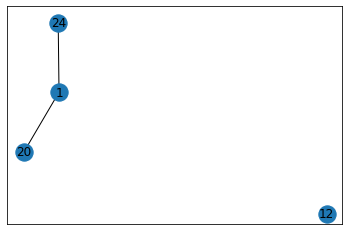


meam = 89


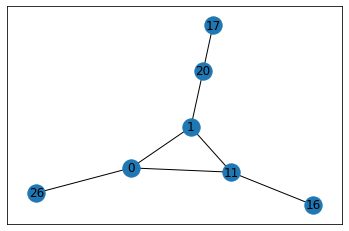


meam = 91


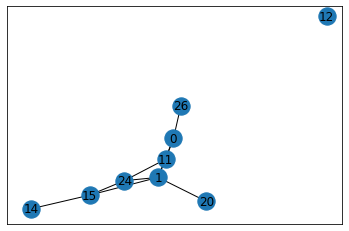


meam = 95


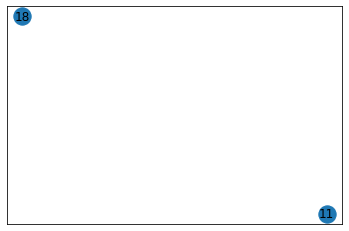


meam = 96


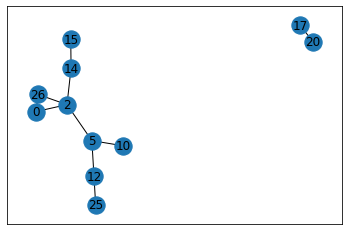


meam = 98


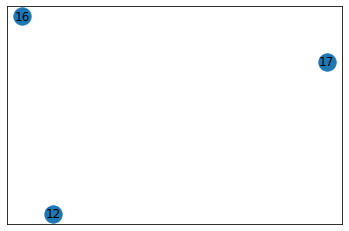


meam = 99


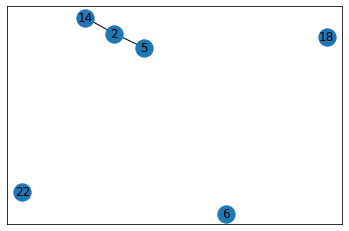


meam = 102


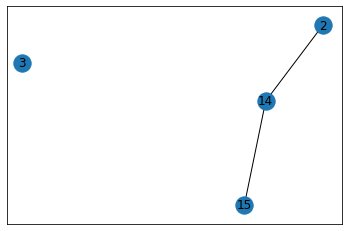


meam = 103


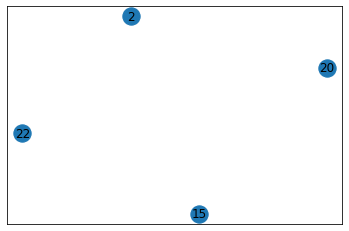


meam = 107


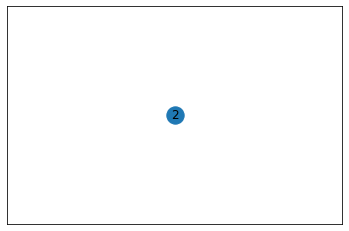


meam = 111


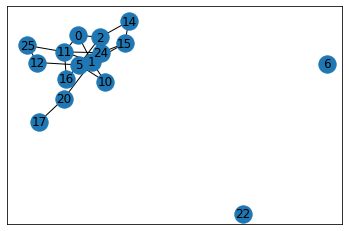


meam = 112


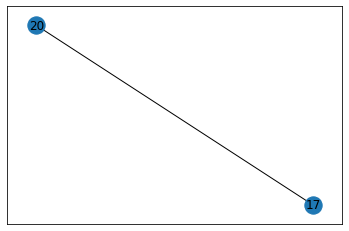


meam = 113


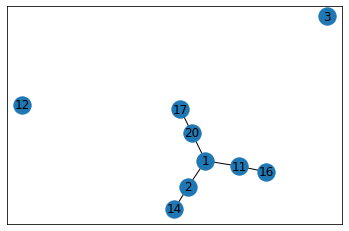


meam = 114


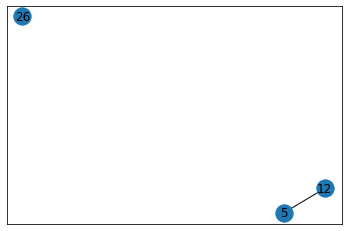


meam = 116


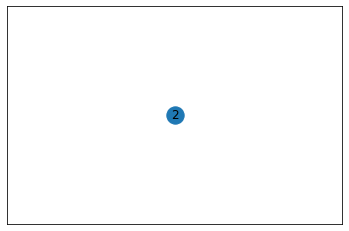


meam = 118


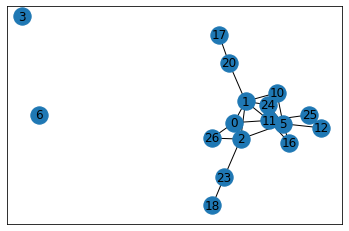


meam = 119


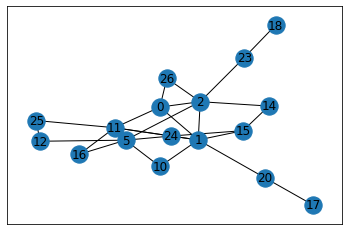


meam = 120


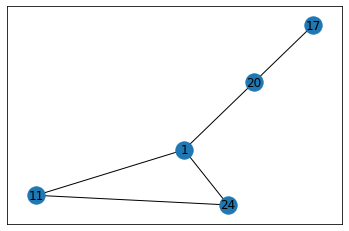


meam = 121


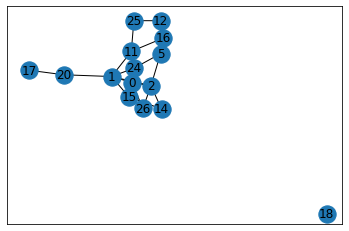


meam = 122


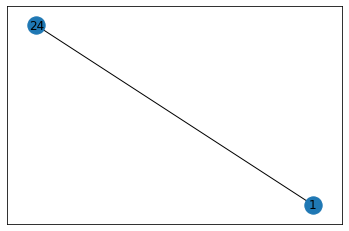


meam = 124


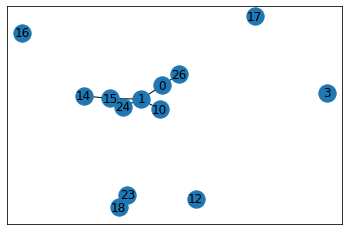


meam = 126


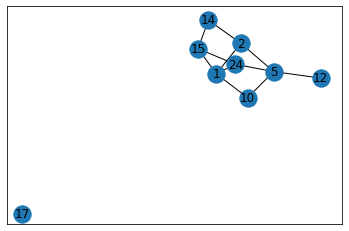


meam = 127


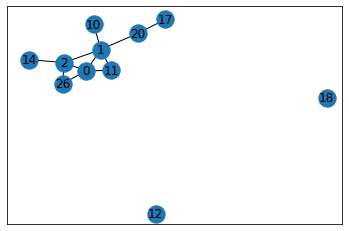


meam = 129


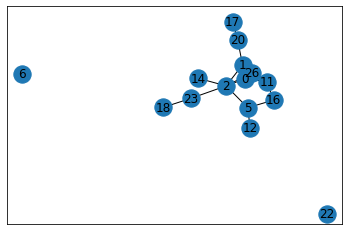


meam = 130


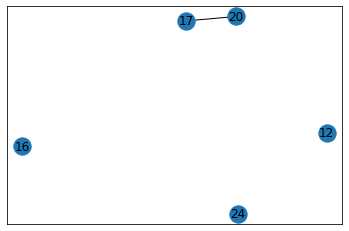


meam = 131


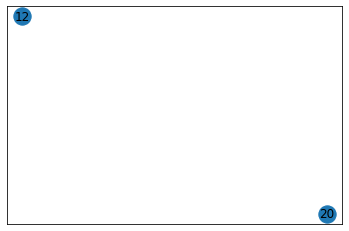


meam = 132


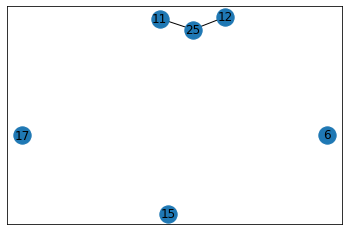


meam = 133


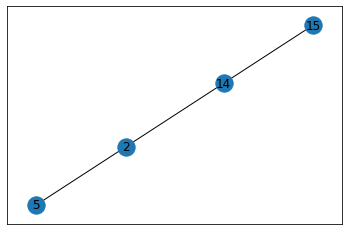


meam = 135


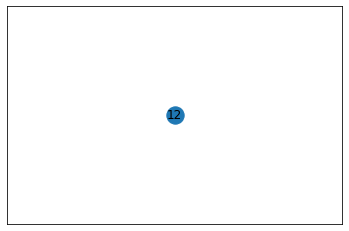


meam = 136


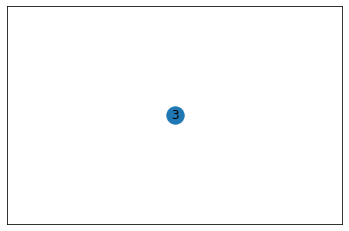


meam = 140


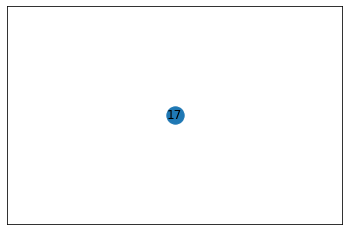


meam = 141


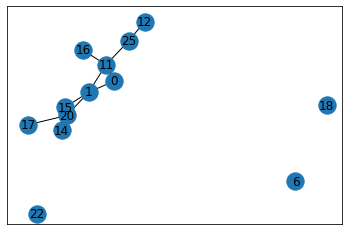


meam = 142


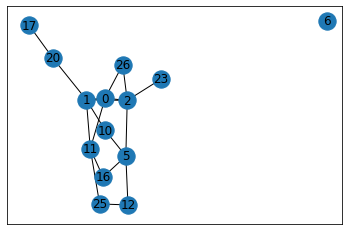


meam = 144


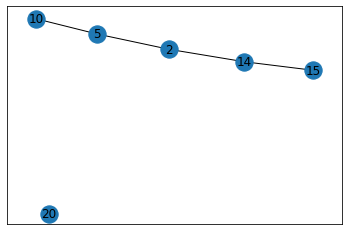


meam = 145


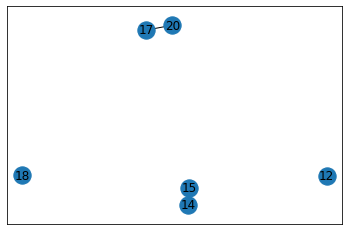


meam = 146


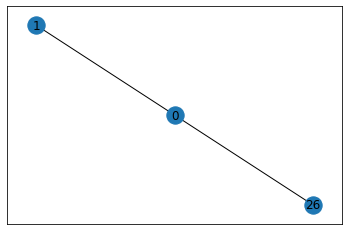


meam = 149


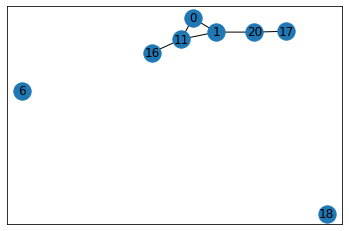


meam = 150


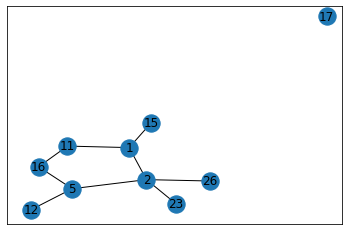


meam = 152


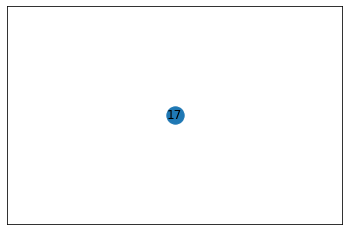


meam = 153


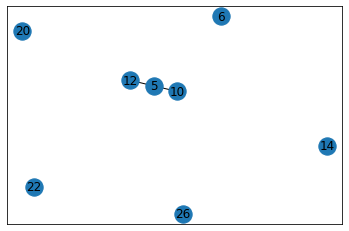


meam = 154


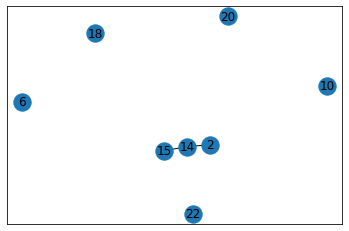


meam = 155


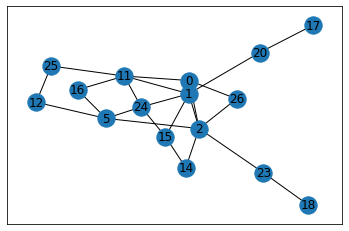


meam = 156


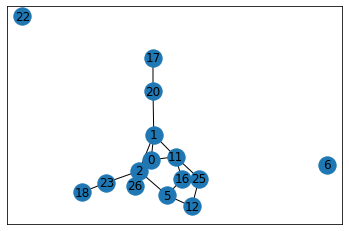


meam = 157


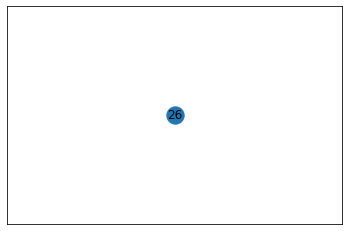


meam = 160


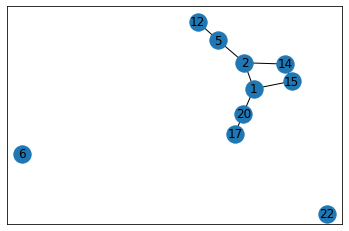


meam = 162


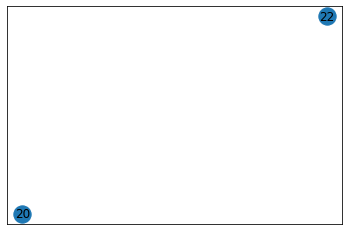


meam = 166


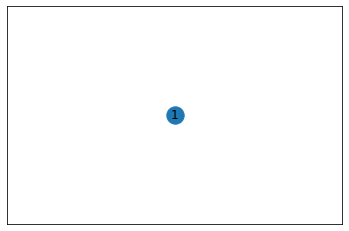


meam = 167


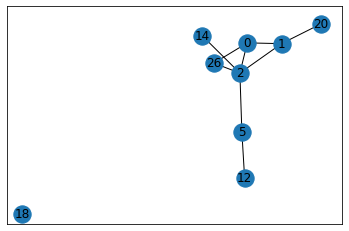


meam = 169


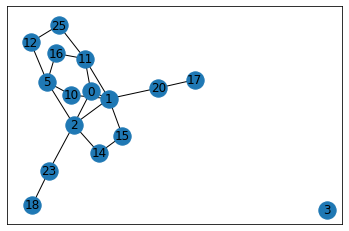


meam = 170


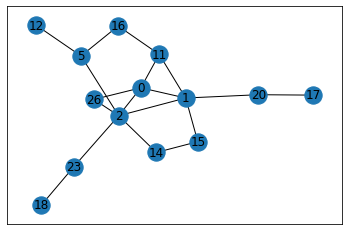


meam = 171


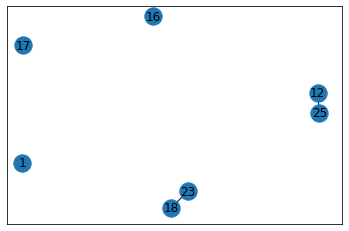


meam = 173


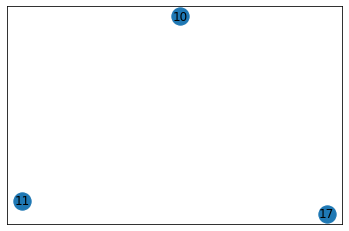


meam = 174


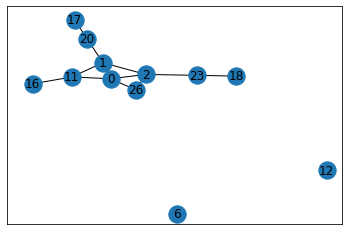


meam = 175


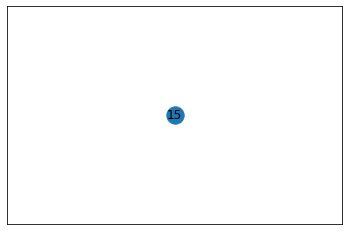


meam = 176


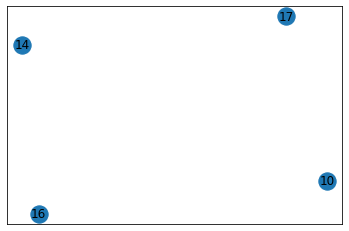


meam = 177


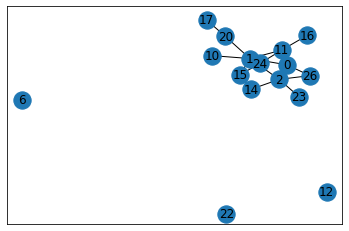


meam = 178


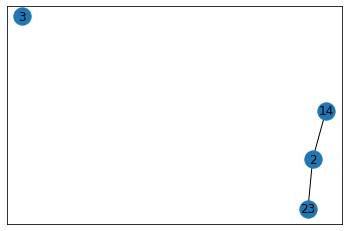


meam = 179


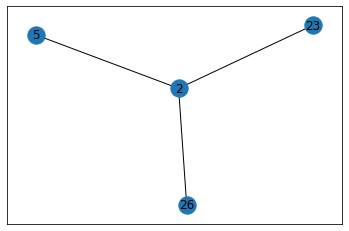


meam = 180


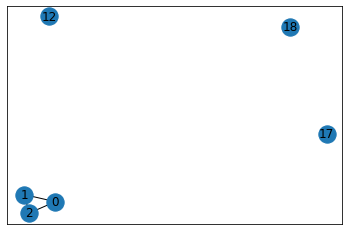


meam = 181


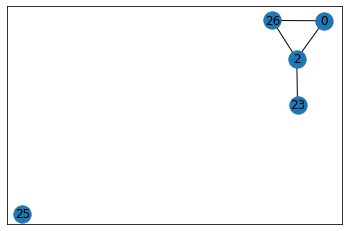


meam = 182


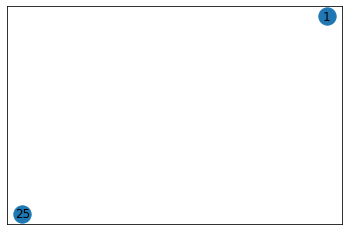


meam = 183


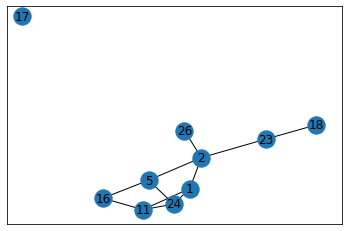


meam = 184


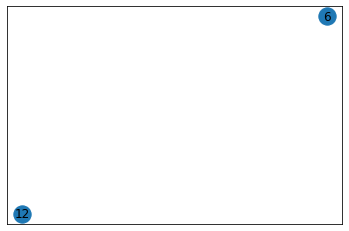


meam = 185


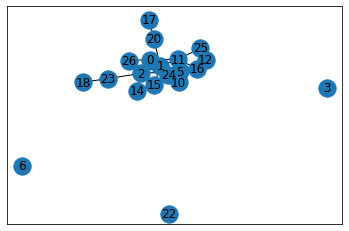


meam = 186


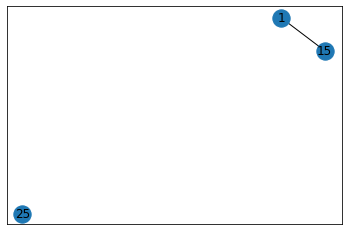


meam = 187


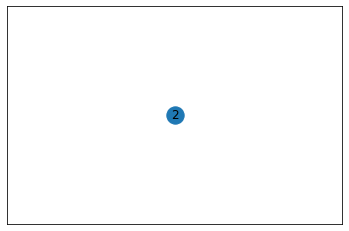


meam = 190


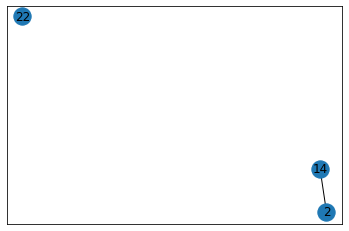


meam = 193


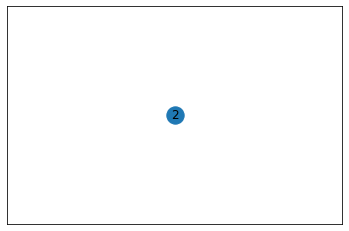


meam = 196


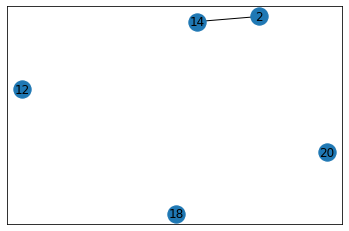


meam = 197


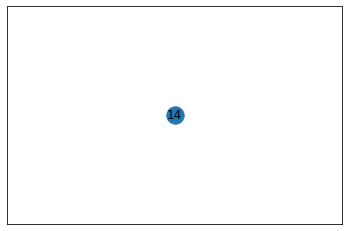

In [15]:
simulator1.plot_meam_network()

time=0
meam = 0


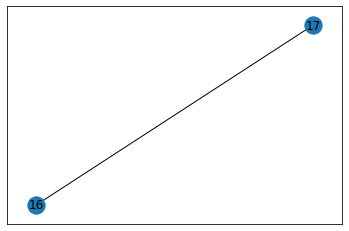


time=1
meam = 0


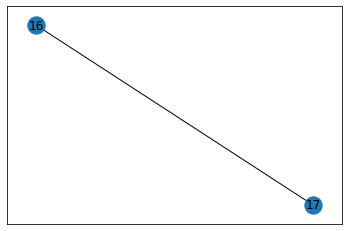


time=2
meam = 0


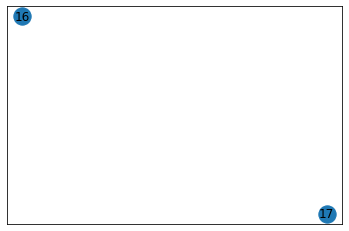


time=3
meam = 0


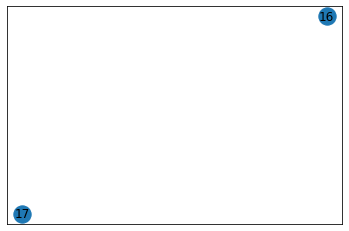


time=4
meam = 0


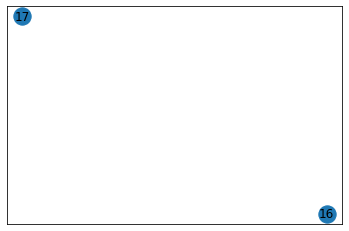


time=5
meam = 0


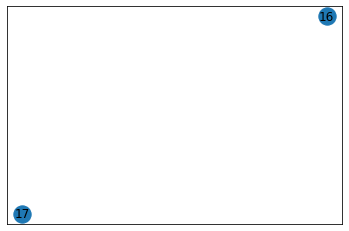


time=6
meam = 0


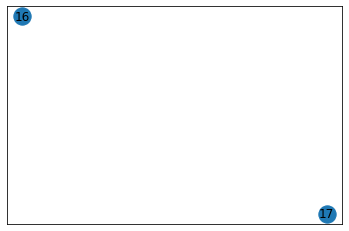


time=7
meam = 0


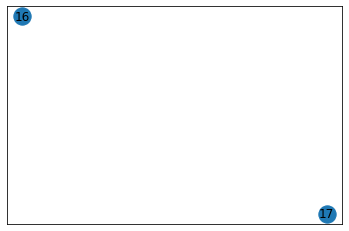


time=8
meam = 0


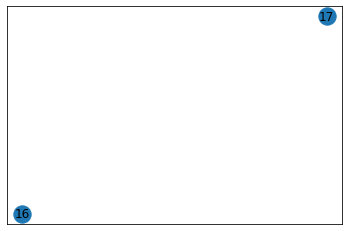


time=9
meam = 0


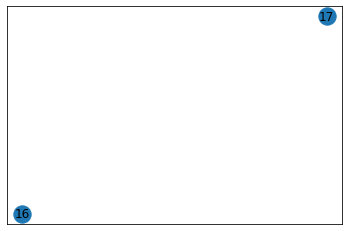


time=10
meam = 0


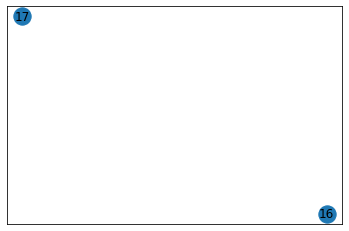


time=11
meam = 0


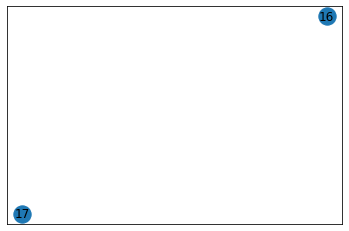


time=12
meam = 0


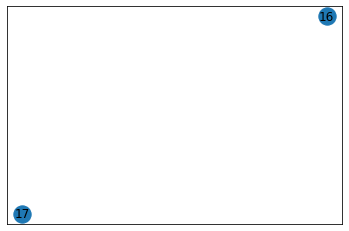


time=13
meam = 0


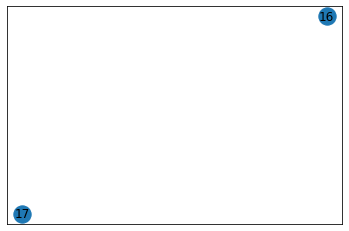


time=14
meam = 0


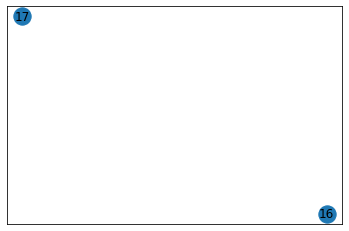


time=15
meam = 0


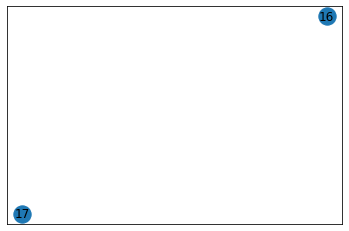


time=16
meam = 0


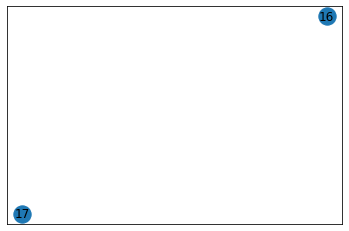


time=17
meam = 0


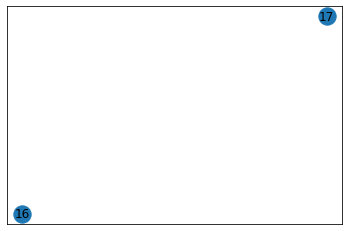


time=18
meam = 0


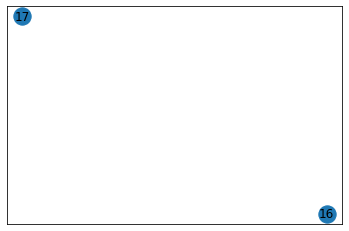


time=19
meam = 0


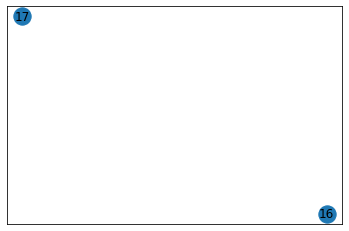


time=20
meam = 0


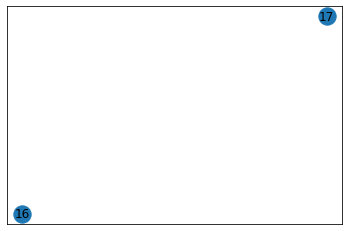


time=21
meam = 0


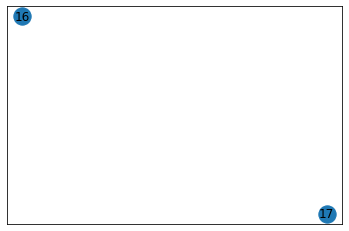


time=22
meam = 0


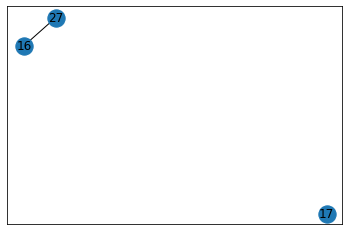


time=23
meam = 0


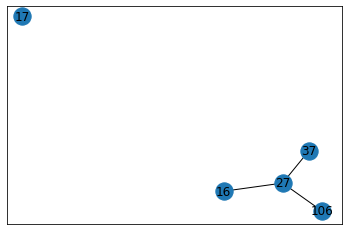


time=24
meam = 0


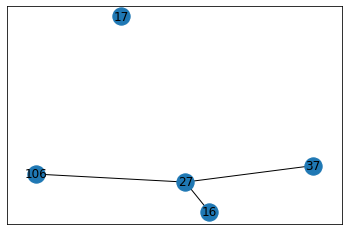


time=25
meam = 0


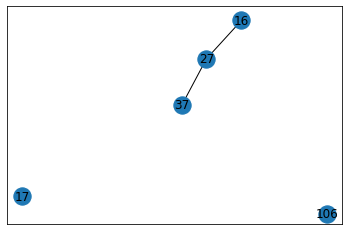


time=26
meam = 0


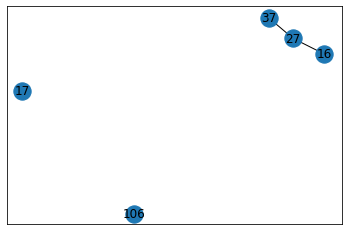


time=27
meam = 0


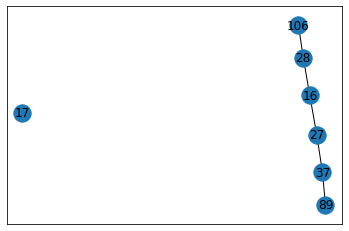


time=28
meam = 0


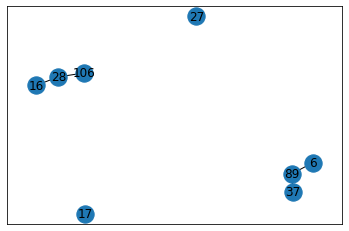


time=29
meam = 0


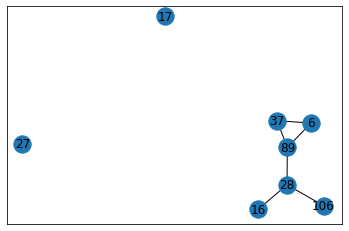


time=30
meam = 0


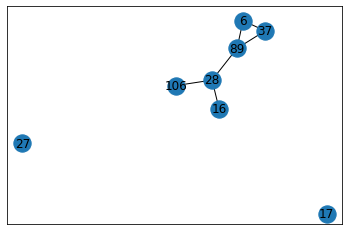


time=31
meam = 0


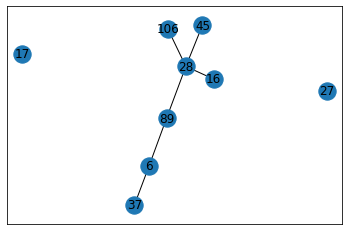


time=32
meam = 0


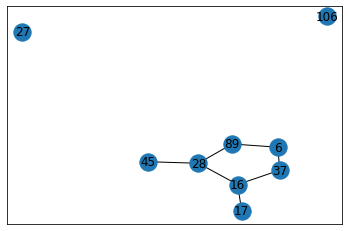


time=33
meam = 0


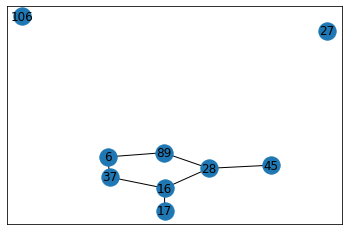


time=34
meam = 0


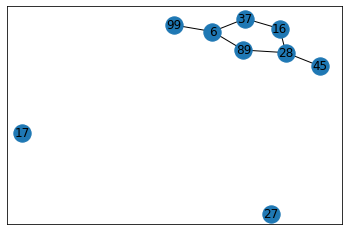


time=35
meam = 0


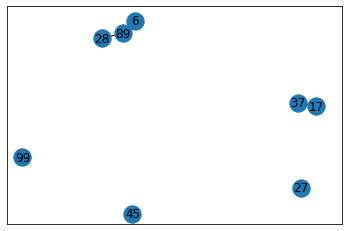


time=36
meam = 0


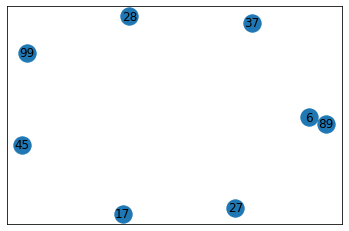


time=37
meam = 0


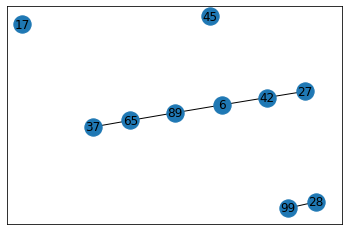


time=38
meam = 0


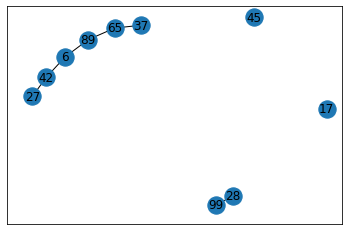


time=39
meam = 0


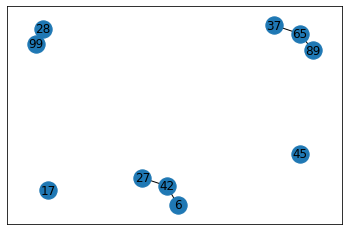


time=40
meam = 0


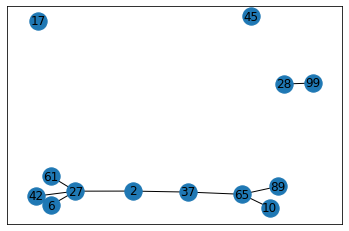


time=41
meam = 0


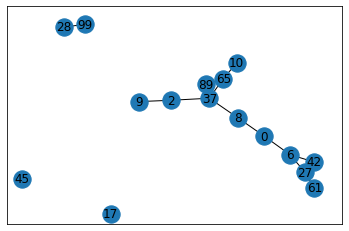


time=42
meam = 0


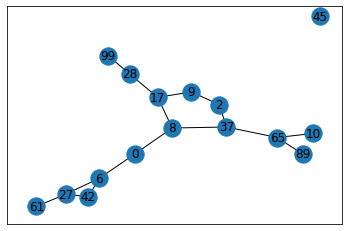


time=43
meam = 0


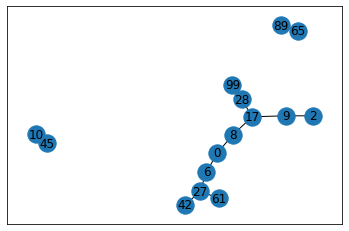


time=44
meam = 0


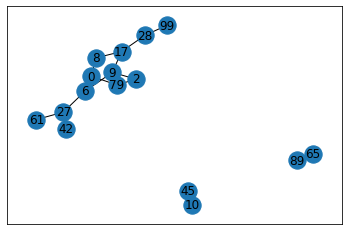


time=45
meam = 0


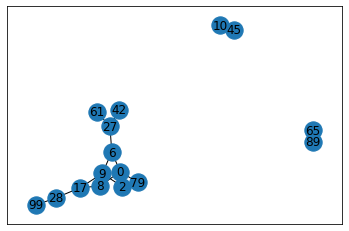


time=46
meam = 0


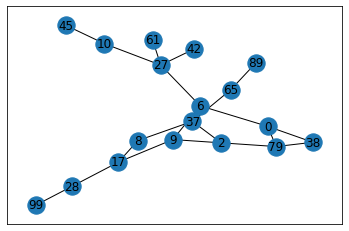


time=47
meam = 0


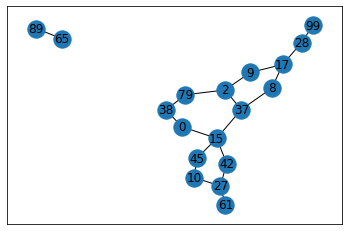


time=48
meam = 0


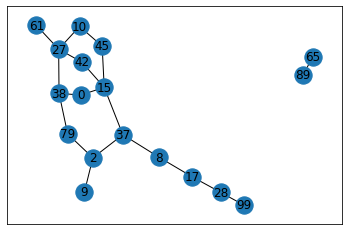


time=49
meam = 0


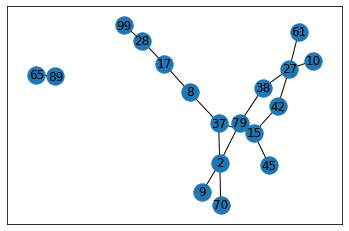


time=50
meam = 0


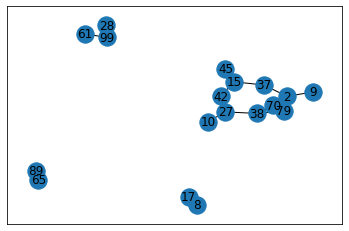


time=51
meam = 0


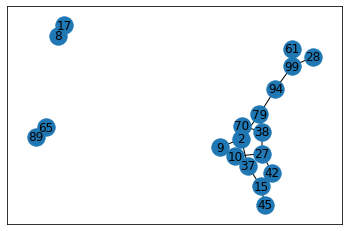


time=52
meam = 0


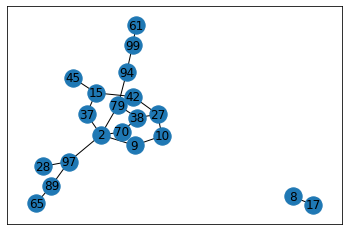


time=53
meam = 0


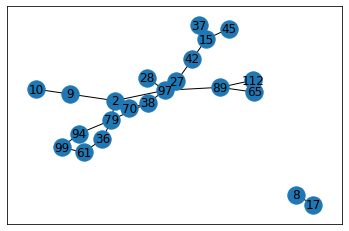


time=54
meam = 0


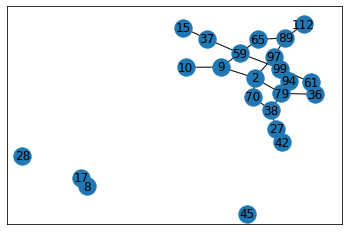


time=55
meam = 0


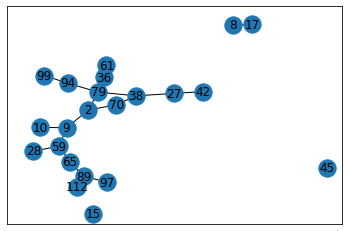


time=56
meam = 0


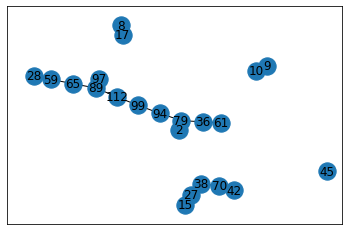


time=57
meam = 0


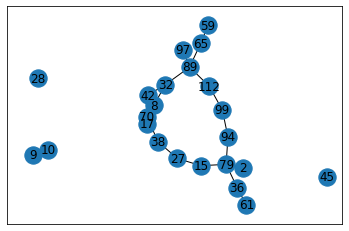


time=58
meam = 0


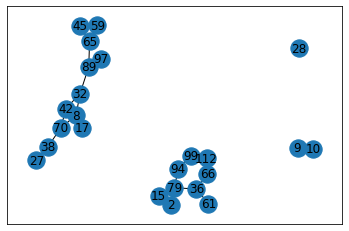


time=59
meam = 0


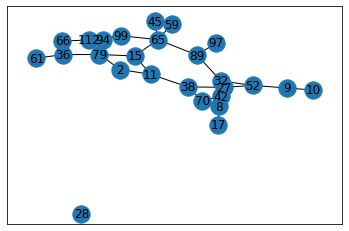


time=60
meam = 0


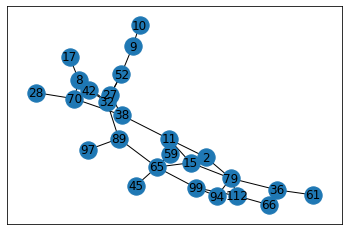


time=61
meam = 0


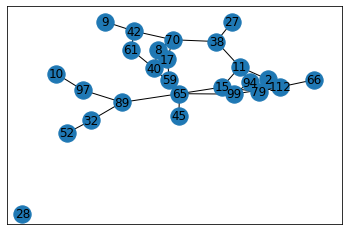


time=62
meam = 0


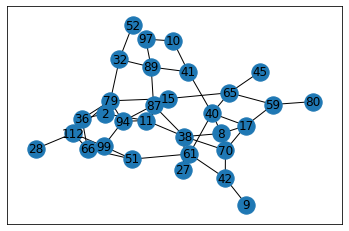


time=63
meam = 0


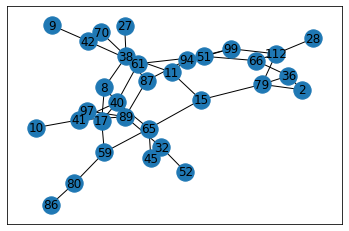


time=64
meam = 0


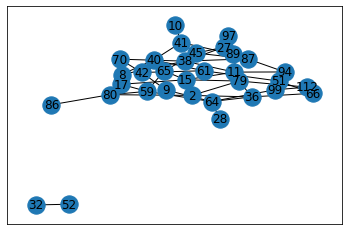


time=65
meam = 0


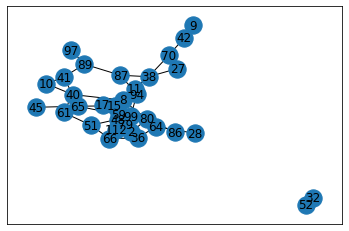


time=66
meam = 0


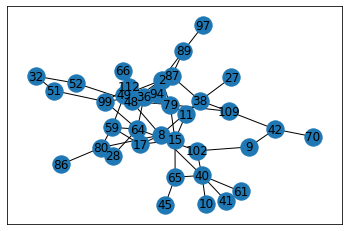


time=67
meam = 0


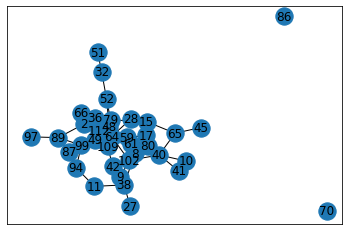


time=68
meam = 0


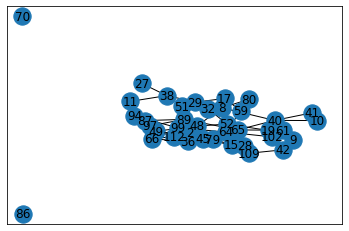


time=69
meam = 0


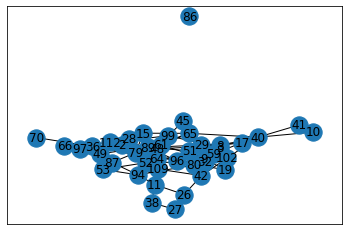


time=70
meam = 0


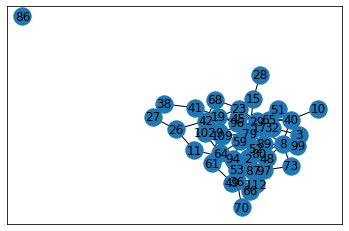


time=71
meam = 0


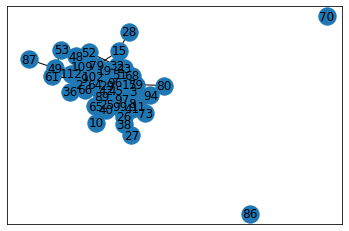


time=72
meam = 0


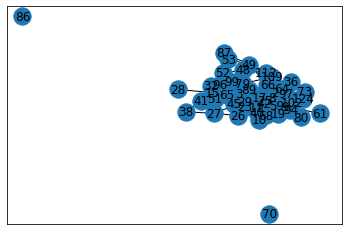


time=73
meam = 0


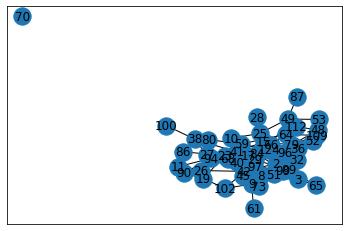


time=74
meam = 0


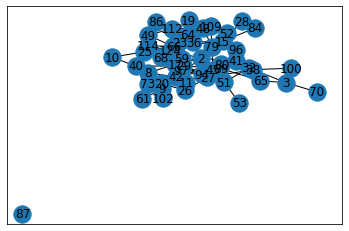


time=75
meam = 0


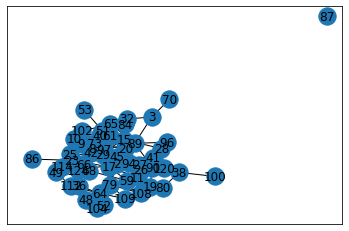


time=76
meam = 0


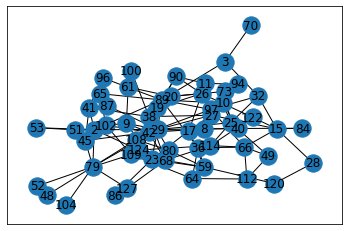


time=77
meam = 0


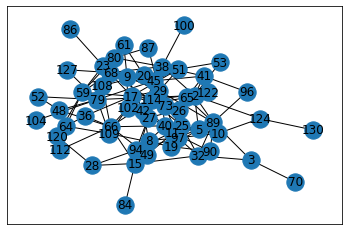


time=78
meam = 0


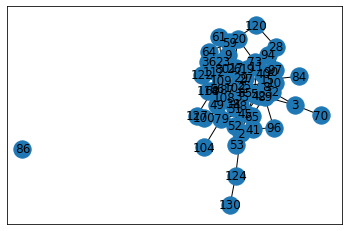


time=79
meam = 0


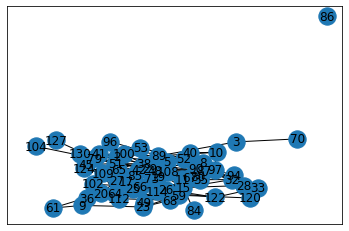


time=80
meam = 0


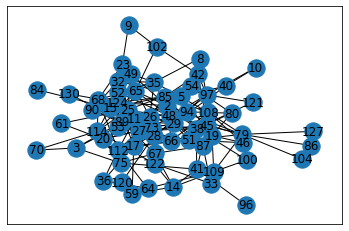


time=81
meam = 0


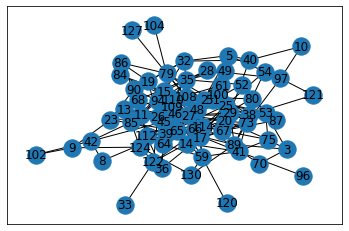


time=82
meam = 0


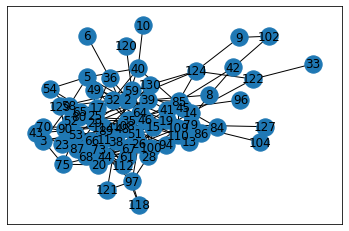


time=83
meam = 0


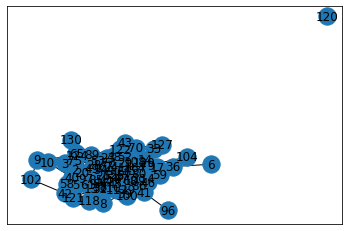


time=84
meam = 0


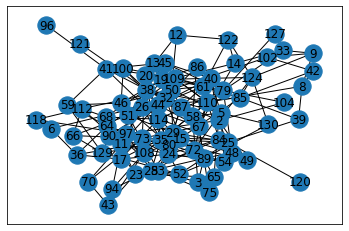


time=85
meam = 0


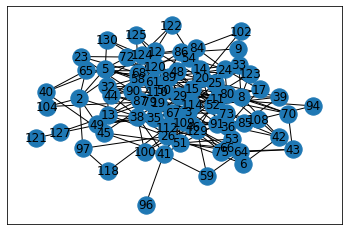


time=86
meam = 0


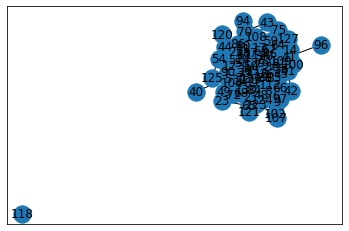


time=87
meam = 0


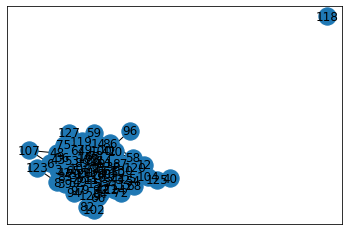


time=88
meam = 0


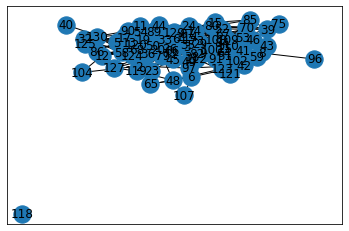


time=89
meam = 0


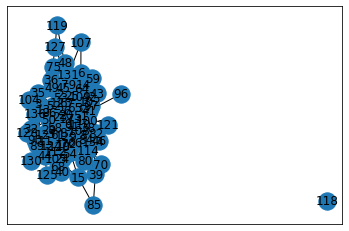


time=90
meam = 0


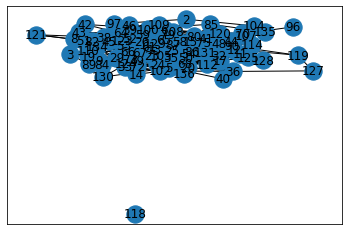


time=91
meam = 0


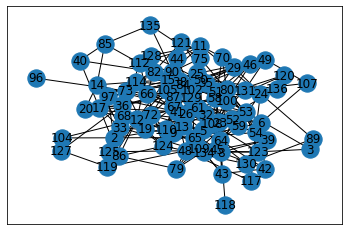


time=92
meam = 0


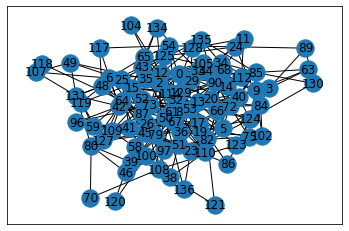


time=93
meam = 0


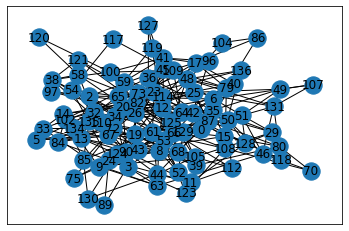


time=94
meam = 0


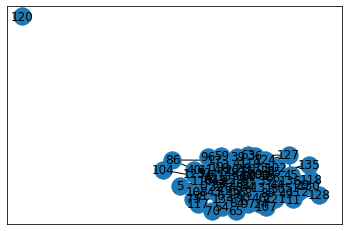


time=95
meam = 0


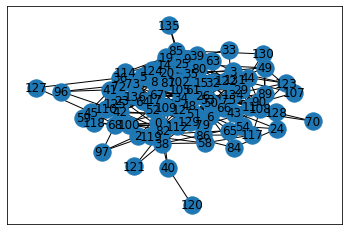


time=96
meam = 0


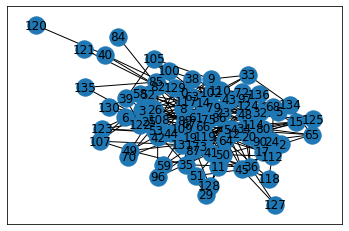


time=97
meam = 0


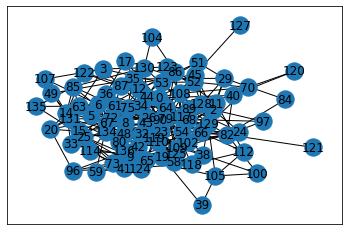


time=98
meam = 0


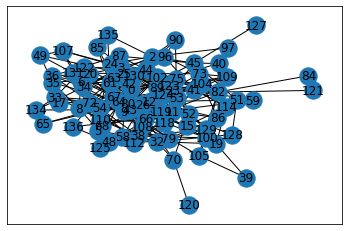


time=99
meam = 0


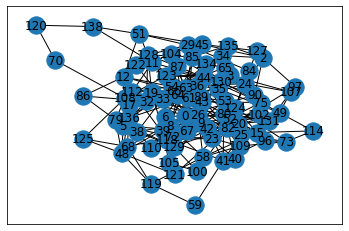

In [16]:
#   一つのミームが時間とともにどのように広まるかを可視化
simulator2 = Simulator(
    init_node_number=100, 
    meam_number=1,  #ミームを一つに指定したしたことで、一つのミームがどのように広まるかを見ることができる
    layer_number=10,
    node_birth_rate=0.005, 
    node_die_rate=0.0045, 
    edge_add_rate=0.4, 
    edge_delete_rate=0.1, 
    meam_generation_rate_per_node=0.01,
    meam_forget_rate=0.01,
    mean_transmittion_rate=0.2,
)
for t in range(100):
    print(f"time={t}")
    simulator2.run(times=1)
    simulator2.plot_meam_network()